In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1 Functions

In [40]:
#=======================================================================
# = Find consecutive missing data
# = Note that missing data at midnight has been filled up with zero
# = In one day, there might be multiple consective missing data vector
# = In the present instance, we simply set a threshold value
# = If the consective missing number lareger than the threshold value
# = the PV sites will be discarded for further algorithm development.
# =======================================================================
def consecutive_missdata(df):
    # return: [[index_start, nannumb], [index_start, nannumb], ...]
    nagroup_df5min = df.notna().cumsum()[df.isna()]
    lengths_consecutive_na = nagroup_df5min.groupby(nagroup_df5min).agg(len)
    indexlist = lengths_consecutive_na.index.values
    valuelist = lengths_consecutive_na.values
    missdata_dic = []
    for j in range(len(lengths_consecutive_na)):

        # only one continuous missing data
        if j == 0:
            nanindex_start = indexlist[0]
            nannum = valuelist[0]
        else:
            nanindex_start = indexlist[j] + np.sum(valuelist[0:j])
            nannum = valuelist[j]
        missdata_dic.append([nanindex_start, nannum])
    return missdata_dic

In [41]:
#=================================================================
# = Function for processing consective missing data
# ================================================================
def process_consecutive_missdata(df, missdata_list, thred, fillmethod):
    # use "nearest"/ inter
    # param missdata_list: [[index, nannum], [index, nanum], ...]
    # param thred: threshold value for filling up or ignoring this pv system
    # param fillmethod: 'linear', ‘time’, ‘pad’, 'nearest' / 'ffill', 'bfill'
    max_consecutivenan = np.max(np.array(missdata_list)[:, 1])
    print('max_consecutivenan:', max_consecutivenan)
    if max_consecutivenan > thred:
        return None
    else:
        if fillmethod == 'linear':
            df = df.interpolate().values
        elif fillmethod == 'time':
            df = df.interpolate(method='time').values
        elif fillmethod == 'nearest':
            df = df.interpolate(method='nearest').values
        elif fillmethod == 'ffill': # Replace NaN with preceding values
            df.fillna(method=fillmethod, inplace=True)
        elif fillmethod == 'bfill': # Replace NaN with backward values
            df.fillna(method=fillmethod, inplace=True)
        else:
            RecursionError('Please check the fill method')
        return df

# 2 Parameters

In [42]:
# ============== set parameters for data collection =============
# Gen.W is AC output for a given monitor
measure_name = 'Gen.W'
time_start = '2022-11-07'
time_end = '2022-11-15'
MID = 'MNTR|987654359'
# MID = 'D36U-90M0-XIHL-0QFU'

# 3 Read data

In [43]:
#-============= read the MID list from MNTR_ddb_2022-10-24.csv file ==============
df_MNTR = pd.read_csv('../input_data/MNTR_ddb_20230630.csv', header=0) 
df_site = pd.read_csv('../input_data/SITE_nodeType_20230630.csv', header=0)
df_MNTR['timezone'] = df_MNTR['siteId'].map(df_site.set_index('source')['timezone'])

In [ ]:
df_5min = pd.read_csv('../preprocessed_data/5min_rawdata_20230630.csv', index_col=0)
# df_5min

In [45]:
df = df_5min[['time', MID]].copy()
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.head()

,MNTR|987654359
time,
2021-01-01 00:00:00+00:00,NaN
2021-01-01 00:05:00+00:00,NaN
2021-01-01 00:10:00+00:00,NaN
2021-01-01 00:15:00+00:00,NaN
2021-01-01 00:20:00+00:00,NaN


<Axes: xlabel='time'>

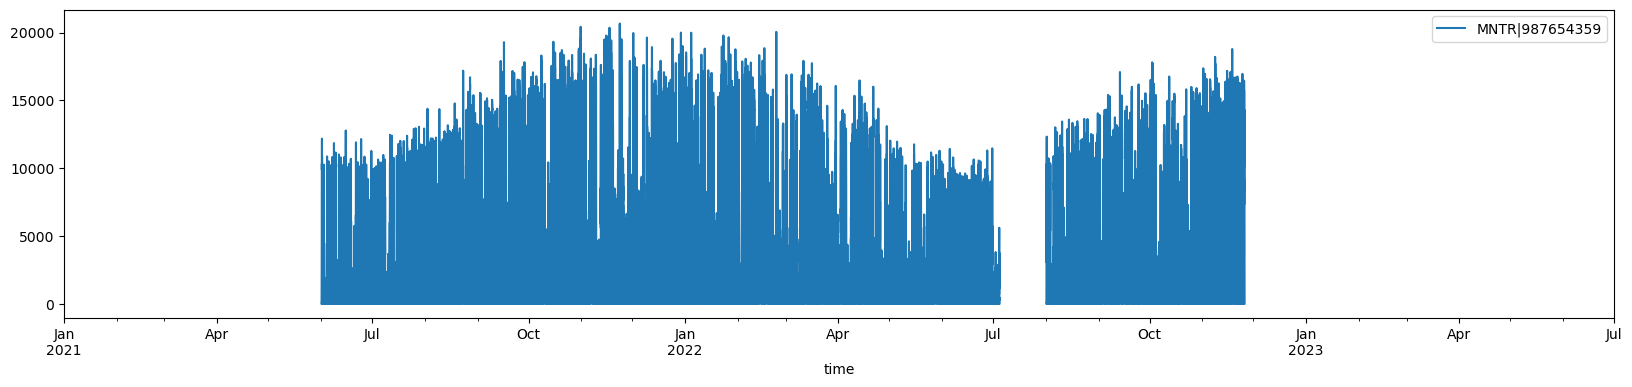

In [46]:
df.plot(figsize=(20, 4))

In [47]:

df_slice = df[(df.index>=time_start) & (df.index<=time_end)].copy()
df_slice

,MNTR|987654359
time,
2022-11-07 00:00:00+00:00,NaN
2022-11-07 00:05:00+00:00,NaN
2022-11-07 00:10:00+00:00,NaN
2022-11-07 00:15:00+00:00,NaN
2022-11-07 00:20:00+00:00,NaN
...,...
2022-11-14 23:40:00+00:00,NaN
2022-11-14 23:45:00+00:00,NaN
2022-11-14 23:50:00+00:00,NaN


In [48]:

df_slice.plot(figsize=(24, 6), lw=2, color='royalblue')
plt.title('MTNR|' + MID, fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.ylabel('Generation (Watt)', fontsize=16)
plt.xlabel('time', fontsize=16)
plt.xticks(fontsize=16)


(array([27796320, 27807840]),
 [Text(27796320, 0, '07\nNov\n2022'), Text(27807840, 0, '15')])

In [ ]:
# =============================== cleaning data ===============================
# Step 1. fill up missing data at midnight with zero  # need to be checked
df_nightmiss = df_slice.copy()
df_nightmiss.reset_index(inplace=True)
df_nightmiss['hour'] = df_nightmiss['time'].dt.hour
nightlist = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5]
df_nightmiss[df_nightmiss['hour'].isin(nightlist)] = df_nightmiss[df_nightmiss['hour'].isin(nightlist)].fillna(0)

In [ ]:
df_nightmiss.set_index('time', inplace=True)
df_nightmiss.drop(columns=['hour'], inplace=True)
df_nightmiss.head()

,MNTR|987654359
time,
2022-11-07 00:00:00,0.0
2022-11-07 00:05:00,0.0
2022-11-07 00:10:00,0.0
2022-11-07 00:15:00,0.0
2022-11-07 00:20:00,0.0


<Axes: xlabel='time'>

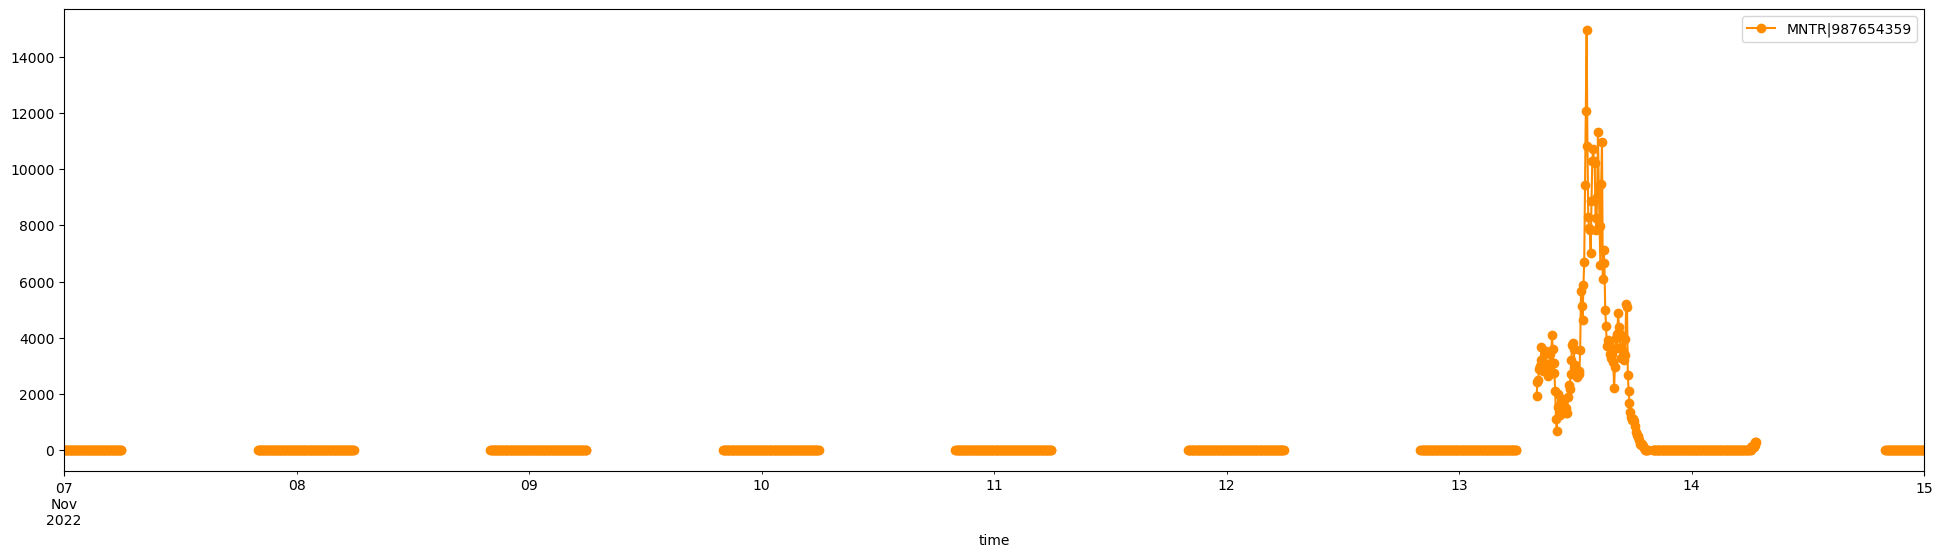

In [ ]:
df_nightmiss.plot(figsize=(24, 6), marker='o', color='darkorange')

<Axes: xlabel='time'>

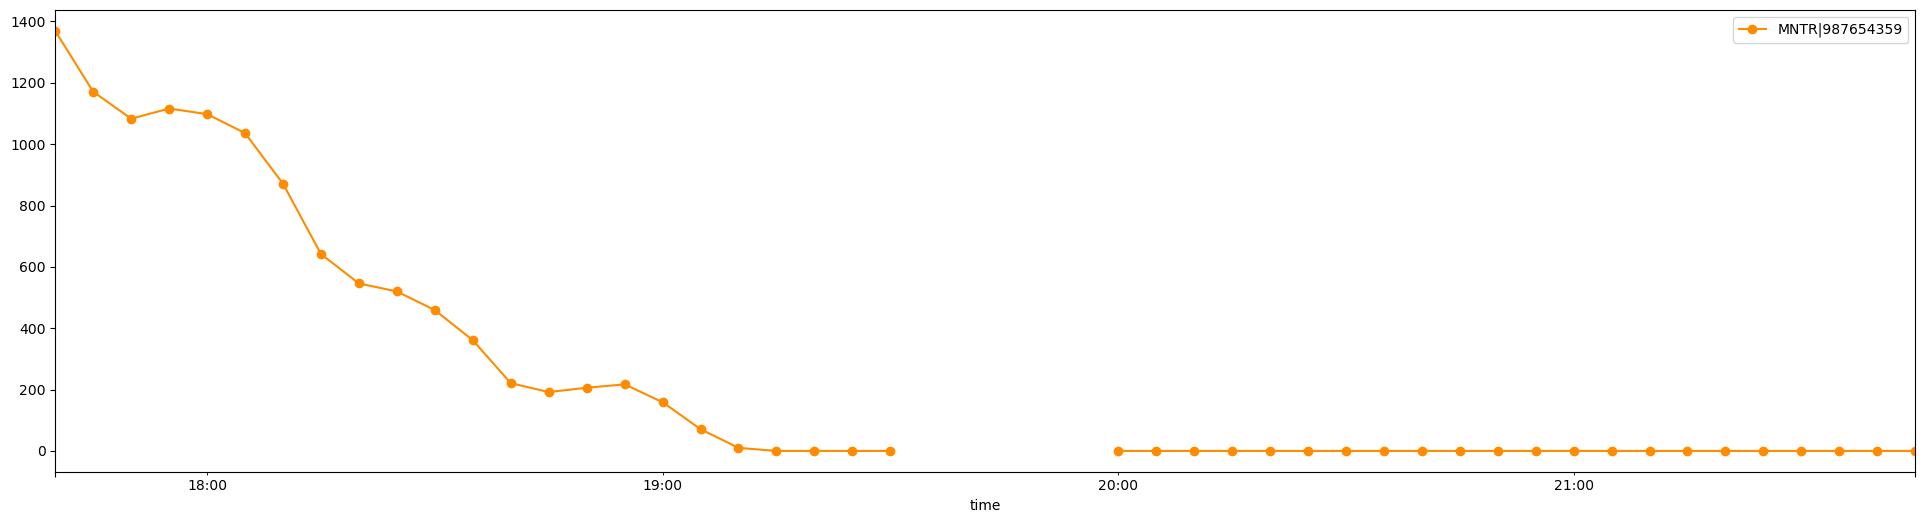

In [ ]:
df_nightmiss.iloc[1940: 1990].plot(figsize=(24, 6), marker='o', color='darkorange')

In [ ]:
# ======= Step 2. find the consecutive missing data, for example there are half an hour missing data with 5-minute resolution
# Check if there is missing data
thred = 6 # half an hour
fillmethod = 'nearest' # you also can choos 'linear' (interpolate), 'ffill', and 'bfill'
if df_nightmiss[MID].isna().sum() >0:
    # find consecutive missing data
    missdata_list = consecutive_missdata(df_nightmiss[MID])
    print(missdata_list)
    # process consecutive missing data
    nonmiss_value = process_consecutive_missdata(df=df_nightmiss, missdata_list=missdata_list,thred=thred, fillmethod=fillmethod)

    df_nomiss = df_nightmiss.copy()
    df_nomiss[MID] = nonmiss_value

[[72, 168], [360, 168], [648, 168], [936, 168], [1224, 168], [1512, 168], [1800, 24], [1963, 5], [2097, 159]]
max_consecutivenan: 168


In [ ]:
df_nomiss.iloc[1940: 1990].plot(figsize=(24, 6),marker='o', color='red')

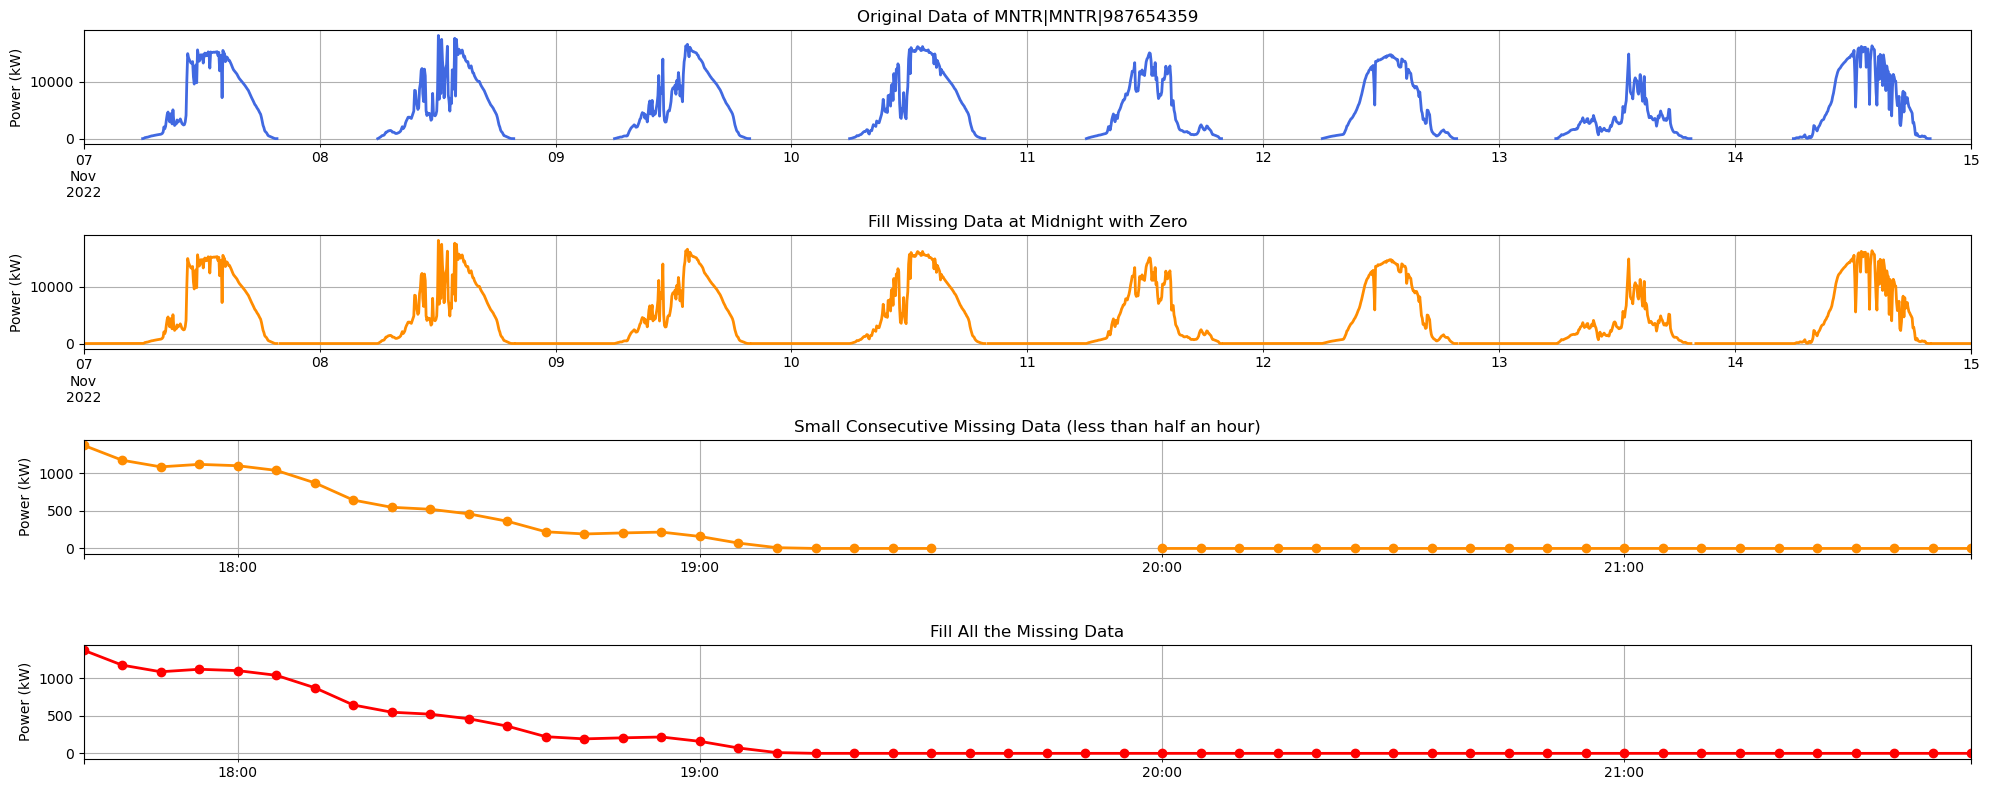

In [ ]:
# ========== plot the preprocessing process step by step =====================
fig, axes = plt.subplots(nrows=4)
df_list = [df_slice, df_nightmiss, df_nightmiss, df_nomiss]
title_list = ['Original Data of MNTR|{}'.format(MID), 'Fill Missing Data at Midnight with Zero', 
              'Small Consecutive Missing Data (less than half an hour)', 'Fill All the Missing Data']
color_list = ['royalblue', 'darkorange', 'darkorange', 'red']

for r in range(4):
    df_plot = df_list[r]
    if r in [2, 3]:
        df_plot = df_plot.iloc[1940: 1990, :]
    # print(df_plot)
    power_max = df_plot.max()
    # print(power_max)
    if r in [2, 3]:
        df_plot.plot(figsize=[20,8], ax = axes[r],legend=None,linewidth=2, color=color_list[r], marker='o')
    else:
        df_plot.plot(figsize=[20,8], ax = axes[r],legend=None,linewidth=2, color=color_list[r])
    axes[r].grid(which='both')
    axes[r].set_title(title_list[r])
    axes[r].set_xlabel('')
    axes[r].set_ylabel('Power (kW)')
    # axes[r].set_ylim([-power_max*0.01, power_max*1.1])
fig.tight_layout()